# Répartition du temps de parole entre les hommes et les femmes dans les médias français

## Imports des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import warnings
warnings.filterwarnings("ignore")

## Structure des données : quelques statistiques descriptives 

In [2]:
# Télécharger depuis la source
# df_stats = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/db598503-d6e5-4e89-8214-167bd239d9e9")

# Version locale
df_stats = pd.read_csv("data/temps_parole_media.csv")

print(f"Format de df_stats : {df_stats.shape}")

Format de df_stats : (1078801, 12)


In [3]:
# Échantillon aléatoire du DataFrame
df_stats.sample(10)

,media_type,channel_code,channel_name,is_public_channel,date,week_day,school_holiday_zones,civil_holyday,hour,male_duration,female_duration,music_duration
889020,tv,LCI,LCI,False,2010-01-29,Friday,NaN,False,17,2469.44,503.90,546.86
388289,radio,RFI,RFI,True,2006-05-02,Tuesday,A,False,5,2454.16,732.90,384.56
429542,radio,RFM,RFM,False,2013-08-15,Thursday,ABC,True,20,93.92,18.54,3483.78
943831,tv,M6,M6,False,2018-01-26,Friday,NaN,False,21,1924.54,588.66,920.14
428600,radio,RFM,RFM,False,2013-01-11,Friday,NaN,False,23,47.98,11.80,3538.62
599257,radio,SKY,Skyrock,False,2017-11-12,Sunday,NaN,False,10,613.60,166.02,2810.92
299636,radio,FUN,Fun Radio,False,2016-12-20,Tuesday,ABC,False,13,442.86,224.86,2930.12
112627,radio,FCR,France Culture,True,2004-08-08,Sunday,ABC,False,23,828.38,1769.10,708.92
1070024,tv,W9,W9,False,2014-05-27,Tuesday,NaN,False,20,1317.82,1012.06,1090.76
233873,radio,FMU,France Musique,True,1997-03-16,Sunday,NaN,False,13,1113.68,25.38,2225.68


Cette DataFrame s'intitule "temps de musique et temps de parole des hommes et des femmes à la TV et à la radio".  Réalisée pour une étude de l'Institut National de l'Audiovisuel (INA) sur la répartition du temps de parole entre les hommes et les femmes à la télévision et à la radio, elle synthétise l’analyse de 1 078 801 heures de programmes diffusés à la télévision et à la radio entre 1995 et 2019. 

Les temps de parole des hommes et des femmes ont été mesurés par une intelligence artificielle développée par l'INA, le logiciel InaSpeechSegmenter basé sur des algorithmes d'apprentissage automatique. Entraînés sur un grand nombre de musique, de voix de femmes et d'hommes afin de détecter les zones de musique et les zones de parole contenues dans les documents audiovisuels, ce logiciel a permis d'analyser un très grand nombre d'heures d'audience.

Comme étudié ci-dessous, cette base de données analyse 21 stations radio: Chérie FM, Europe 1, France Bleu, France Culture, France Info, France Inter, France Musique, Fun Radio, Mouv’, NRJ, Nostalgie, RFM, RMC, RTL, RTL 2, Radio Classique, Radio France Internationale, Rire et Chansons, Skyrock, Sud Radio et Virgin Radio.

D'autre part, elle comprend 34 chaînes de TV: Arte, Animaux, BFM TV, Canal+, Canal+ Sport, Chasse et pêche, Chérie 25, Comédie+, D8/C8, Euronews, Eurosport France, France 2, France 24, France 3, France 5, France O, Histoire, I-Télé/CNews, L'Equipe 21, LCI, LCP/Public Sénat, La chaîne Météo, M6, Monte Carlo TMC, NRJ 12, Paris Première, Planète+, TF1, TV Breizh, TV5 Monde, Toute l'Histoire, Téva, Voyage, W9. 

In [4]:
# Création de la colonne "year" et de la colonne "months" à partir de la colonne "date"
df_stats["year"] = pd.to_datetime(df_stats["date"]).dt.year
df_stats["month"] = pd.to_datetime(df_stats["date"]).dt.month

In [5]:
# nombre d'heures analysées
df_stats["hour"].count()

np.int64(1078801)

In [6]:
print(f"Date miniumum : {df_stats['date'].min()}")
print(f"Date maximum  : {df_stats['date'].max()}")
print(
    f'Le nombre de station radio est : {df_stats.loc[df_stats["media_type"] == "radio", "channel_name"].nunique()}'
)
print(
    f'Le nombre de chaînes tv est : {df_stats.loc[df_stats["media_type"] == "tv", "channel_name"].nunique()}'
)

Date miniumum : 1995-01-01
Date maximum  : 2019-02-28
Le nombre de station radio est : 21
Le nombre de chaînes tv est : 34


In [7]:
# nombre d'entrées radio et nombre d'entrées tv
print("Types de media:")
df_stats["media_type"].value_counts()

Types de media:


media_type
radio    636822
tv       441979
Name: count, dtype: int64

In [8]:
# nombre d'entrées par stations radio au sein du "media_type" radio
print("Canaux radio :")
df_stats.loc[df_stats["media_type"] == "radio", "channel_name"].value_counts()

Canaux radio :


channel_name
France Culture      47206
France Musique      46526
France Inter        44438
France Info         44259
RFI                 33192
France Bleu         32035
RMC                 31763
RTL                 31760
Europe 1            31695
Skyrock             30634
Chérie FM           29631
RTL 2               29628
Fun Radio           29605
NRJ                 29593
Nostalgie           29464
RFM                 29381
Virgin Radio        20150
Radio Classique     20125
Rire et Chansons    18746
MOUV                13635
Sud Radio           13356
Name: count, dtype: int64

In [9]:
# nombre d'entrées par chaines tv au sein du "media_type" tv
print("Canaux tv :")
df_stats.loc[df_stats["media_type"] == "tv", "channel_name"].value_counts()

Canaux tv :


channel_name
NRJ 12              16279
France 5            16270
I-Télé/CNews        16246
TF1                 16211
Monte Carlo TMC     16180
LCP/Public Sénat    16156
M6                  16148
Canal+              16108
LCI                 16107
W9                  16090
France 2            16089
BFM TV              16065
France 3            16021
ARTE                15976
France O            15716
Eurosport France    15264
France 24           14514
Histoire            13416
Téva                13231
D8/C8               11933
L'Equipe 21         11225
Chérie 25           11047
Toute l'Histoire     9332
Canal+ Sport         9331
Comédie+             9321
La chaîne Météo      9290
Paris Première       9277
Animaux              9219
Chasse et pêche      9179
TV5 Monde            9170
Voyage               9161
Euronews             9128
Planète+             9094
TV Breizh            8185
Name: count, dtype: int64

## Analyse descriptive des données

À ce stade, la granularité temporelle est l'heure. Chaque ligne rend compte de ce qu'il s'est passé, pendant l'heure donnée, un certain jour, sur un canal donné.
Le temps est en secondes (1h = 3600 secondes). 

### Calcul des ratios

In [10]:
# création d'une fonction ratio qui permet d'ajouter quatres nouvelles colonnes à la base de données :
# women_expression_rate, men_expression_rate, music_rate, speech_rate

def ratio(df):
    df = df.copy()
    df["women_expression_rate"] = df["female_duration"] / (
        df["female_duration"] + df["male_duration"]
    )
    df["men_expression_rate"] = df["male_duration"] / (
        df["female_duration"] + df["male_duration"]
    )
    df["music_rate"] = df["music_duration"] / (
        df["female_duration"] + df["male_duration"] + df["music_duration"]
    )
    df["speech_rate"] = (df["female_duration"] + df["male_duration"]) / (
        df["female_duration"] + df["male_duration"] + df["music_duration"]
    )
    return df

### Agrégation à l'année et par chaîne

Changement de granularité. Le niveau d'étude n'est plus la journée désormais mais l'année.

In [11]:
# On a précédemment ajouté une colonne year au tableau.
# On aggrège par année, ie on rassemble au sein d'une même ligne toutes les différentes lignes ayant le même "media_type", "channel_code", "channel_name", "is_public_channel" et "year"
# On somme sur ces lignes les male_duration, female_duration, music_duration pour avoir un total par jour et on compte les "hour" (car le chiffre reporté dans la colonne heure correspond à l'heure d'enregistrement de l'écoute)
# Cela permet de définir à nouveau une nouvelle base de données : df_year_level

df_year_level = (
    df_stats.groupby(
        [
            "media_type",
            "channel_code",
            "channel_name",
            "is_public_channel",
            "year",
        ]
    )
    .agg(
        {
            "male_duration": "sum",
            "female_duration": "sum",
            "music_duration": "sum",
            "hour": "count",
        }
    )
    .reset_index()
    .rename(
        columns={
            "hour": "nb_hours_analyzed",
        }
    )
)
df_year_level.head(5)

,media_type,channel_code,channel_name,is_public_channel,year,male_duration,female_duration,music_duration,nb_hours_analyzed
0,radio,CHE,Chérie FM,False,2001,126155.28,109742.76,1262835.12,417
1,radio,CHE,Chérie FM,False,2002,214585.64,191134.56,2172131.50,718
2,radio,CHE,Chérie FM,False,2003,509472.92,434597.64,4865502.12,1617
3,radio,CHE,Chérie FM,False,2004,457974.02,429290.66,5013886.88,1644
4,radio,CHE,Chérie FM,False,2005,511031.10,425809.12,4895164.16,1624


In [12]:
# Ratio par chaîne et par année
df_year_level = ratio(df_year_level)
df_year_level.head(5)

,media_type,channel_code,channel_name,is_public_channel,year,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
0,radio,CHE,Chérie FM,False,2001,126155.28,109742.76,1262835.12,417,0.465213,0.534787,0.842602,0.157398
1,radio,CHE,Chérie FM,False,2002,214585.64,191134.56,2172131.50,718,0.471099,0.528901,0.842613,0.157387
2,radio,CHE,Chérie FM,False,2003,509472.92,434597.64,4865502.12,1617,0.460344,0.539656,0.837497,0.162503
3,radio,CHE,Chérie FM,False,2004,457974.02,429290.66,5013886.88,1644,0.483836,0.516164,0.849646,0.150354
4,radio,CHE,Chérie FM,False,2005,511031.10,425809.12,4895164.16,1624,0.454516,0.545484,0.839362,0.160638


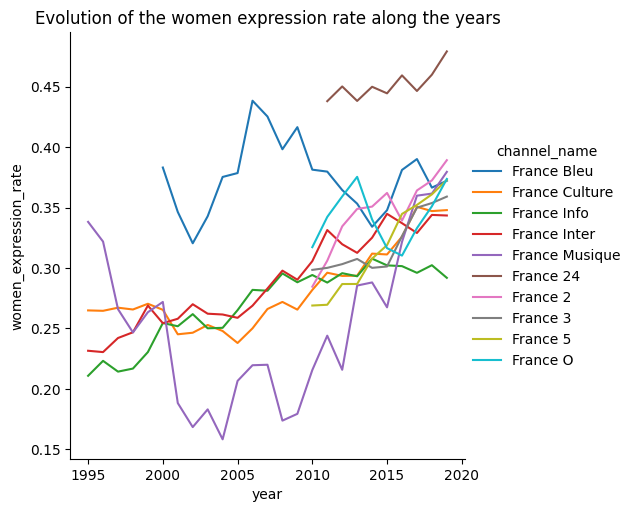

In [13]:
sns.relplot(
    x="year",
    y="women_expression_rate",
    hue="channel_name",
    dashes=False,
    markers=True,
    kind="line",
    data=df_year_level[df_year_level["channel_name"].str.startswith("France")],
)
plt.title("Evolution of the women expression rate along the years")
plt.show()

L'évolution des chaines de télévision du groupe France télévisions et du groupe Radio France présente, sur la période 1995-2019, des women_expression_rate tous compris entre 0.17 et 0.35, à l'exception de deux chaînes. On est dans l'ensemble très loin de la parité, à l'exception de France 24 qui se situe toutes années confondues bien au-dessus des autres chaines/stations.

### Agrégation par chaine seulement et distinction public et privé

Quelles chaines donnent le plus la parole aux femmes ?\
Quelles stations radio donnent le plus la parole aux femmes ?\
Qu'en est-il des chaines de sport?

Remarque : dans la DataFrame sont distinguées channel_name et channel_code. Une même chaîne/station peut avoir deux channel_code du fait d'un changement de nom entre 1995 et 2019 mais elles n'auront qu'un channel_name. 
Donc le regroupement est fait par channel_name et non channel_code pour n'avoir qu'une ligne par chaîne. 

In [14]:
# But: obtenir désormais une entrée par chaîne

df_channel_level = (
    df_stats.groupby(
        [
            "media_type",
            "channel_name",
            "is_public_channel",
        ]
    )
    .agg(
        {
            "male_duration": "sum",
            "female_duration": "sum",
            "music_duration": "sum",
            "hour": "count",
        }
    )
    .reset_index()
    .rename(
        columns={
            "hour": "nb_hours_analyzed",
        }
    )
)
df_channel_level.head(5)

,media_type,channel_name,is_public_channel,male_duration,female_duration,music_duration,nb_hours_analyzed
0,radio,Chérie FM,False,9.517309e+06,9440329.78,87461361.76,29631
1,radio,Europe 1,False,7.285244e+07,30174586.82,9782977.26,31695
2,radio,France Bleu,True,2.939030e+07,17208604.42,67711909.42,32035
3,radio,France Culture,True,1.029863e+08,40384056.02,20204651.92,47206
4,radio,France Info,True,1.092656e+08,39970269.42,9004316.96,44259


In [15]:
# Ratio par chaîne
df_channel_level = ratio(df_channel_level)
df_channel_level.head(5)

,media_type,channel_name,is_public_channel,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
0,radio,Chérie FM,False,9.517309e+06,9440329.78,87461361.76,29631,0.497970,0.502030,0.821859,0.178141
1,radio,Europe 1,False,7.285244e+07,30174586.82,9782977.26,31695,0.292880,0.707120,0.086721,0.913279
2,radio,France Bleu,True,2.939030e+07,17208604.42,67711909.42,32035,0.369292,0.630708,0.592349,0.407651
3,radio,France Culture,True,1.029863e+08,40384056.02,20204651.92,47206,0.281676,0.718324,0.123519,0.876481
4,radio,France Info,True,1.092656e+08,39970269.42,9004316.96,44259,0.267833,0.732167,0.056903,0.943097


In [16]:
# Classement des chaînes par ordre décroissant du women_expression_rate
# on reset.index pour clarifier le classement
df_channel_sorted = df_channel_level.sort_values(
    by="women_expression_rate", ascending=False
).reset_index(drop=True)
df_channel_sorted.head(5)

,media_type,channel_name,is_public_channel,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
0,radio,Chérie FM,False,9517309.30,9440329.78,87461361.76,29631,0.497970,0.502030,0.821859,0.178141
1,tv,Téva,False,16710698.24,15667061.64,13247179.58,13231,0.483883,0.516117,0.290350,0.709650
2,tv,France 24,True,24866423.66,20371678.28,5637806.08,14514,0.450321,0.549679,0.110815,0.889185
3,tv,Chérie 25,False,16743406.78,12574077.52,9138546.28,11047,0.428893,0.571107,0.237636,0.762364
4,tv,M6,False,24781593.00,17326081.44,13899142.60,16148,0.411471,0.588529,0.248169,0.751831


In [17]:
# pour rechercher le classement d'une station/chaîne dans la DataFrame des classements
# dans search on peut mettre n'importe quelle des chaînes tv ou radio présente dans la DataFrame
# examples
search = "France Inter"
df_channel_sorted.loc[df_channel_sorted["channel_name"].str.contains(search)]

# ou
search = "D8"
df_channel_sorted.loc[df_channel_sorted["channel_name"].str.contains(search)]

,media_type,channel_name,is_public_channel,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
35,tv,D8/C8,False,22336333.44,8723069.96,10126143.14,11933,0.280851,0.719149,0.245866,0.754134


In [18]:
# Classement parmi les radios uniquement
df_channel_sorted_radio_only = df_channel_sorted.loc[
    df_channel_sorted["media_type"] == "radio"
]
df_channel_sorted_radio_only

# Chérie FM
#df_channel_sorted_radio_only.head(5)

# Skyrock
df_channel_sorted_radio_only.tail(5)

,media_type,channel_name,is_public_channel,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
39,radio,Rire et Chansons,False,33367968.36,11787961.94,2.100481e+07,18746,0.261050,0.738950,0.317481,0.682519
40,radio,France Musique,True,28491439.32,9808112.62,1.205301e+08,46526,0.256089,0.743911,0.758864,0.241136
41,radio,NRJ,False,21445510.76,7020628.08,7.733789e+07,29593,0.246631,0.753369,0.730954,0.269046
47,radio,RMC,False,87282041.04,20354646.78,5.534677e+06,31763,0.189105,0.810895,0.048905,0.951095
49,radio,Skyrock,False,29466824.10,6141566.78,7.392358e+07,30634,0.172475,0.827525,0.674904,0.325096


In [19]:
# Classement parmi les chaines tv uniquement
df_channel_sorted_tv_only = df_channel_sorted.loc[
    df_channel_sorted["media_type"] == "tv"
]
df_channel_sorted_tv_only

# Téva
df_channel_sorted_tv_only.head()
# Canal+Sport
df_channel_sorted_tv_only.tail()

,media_type,channel_name,is_public_channel,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
50,tv,Planète+,False,20838486.56,4289691.76,6661739.58,9094,0.170712,0.829288,0.209555,0.790445
51,tv,L'Equipe 21,False,29407041.70,5492367.46,4475337.84,11225,0.157377,0.842623,0.113660,0.886340
52,tv,Chasse et pêche,False,21148376.82,2142739.78,8617440.30,9179,0.091998,0.908002,0.270067,0.729933
53,tv,Eurosport France,False,42539517.24,3382002.36,7079254.76,15264,0.073647,0.926353,0.133569,0.866431
54,tv,Canal+ Sport,False,27391333.24,1489294.84,3977827.34,9331,0.051567,0.948433,0.121059,0.878941


In [20]:
# Classement des chaînes privées en terme de women_expression_rate
df_channel_sorted.loc[df_channel_sorted["is_public_channel"] == False]

# Classement des chaînes publiques en terme de women_expression_rate
df_channel_sorted.loc[df_channel_sorted["is_public_channel"] == True]

,media_type,channel_name,is_public_channel,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
2,tv,France 24,True,2.486642e+07,20371678.28,5.637806e+06,14514,0.450321,0.549679,0.110815,0.889185
7,radio,France Bleu,True,2.939030e+07,17208604.42,6.771191e+07,32035,0.369292,0.630708,0.592349,0.407651
13,tv,France 2,True,2.990596e+07,15656992.16,1.002128e+07,16089,0.343634,0.656366,0.180290,0.819710
14,tv,France O,True,2.686413e+07,13800376.00,1.376098e+07,15716,0.339372,0.660628,0.252841,0.747159
20,tv,France 3,True,3.022706e+07,14135135.70,1.056579e+07,16021,0.318630,0.681370,0.192357,0.807643
21,radio,RFI,True,7.131931e+07,33260284.76,1.348755e+07,33192,0.318038,0.681962,0.114236,0.885764
22,tv,France 5,True,3.226139e+07,14853545.10,9.753600e+06,16270,0.315262,0.684738,0.171511,0.828489
24,tv,TV5 Monde,True,1.840130e+07,8143047.42,5.494103e+06,9170,0.306771,0.693229,0.171485,0.828515
27,tv,LCP/Public Sénat,True,3.698992e+07,15734200.16,3.486262e+06,16156,0.298425,0.701575,0.062022,0.937978
30,tv,ARTE,True,2.958566e+07,12194814.24,1.339190e+07,15976,0.291878,0.708122,0.242728,0.757272


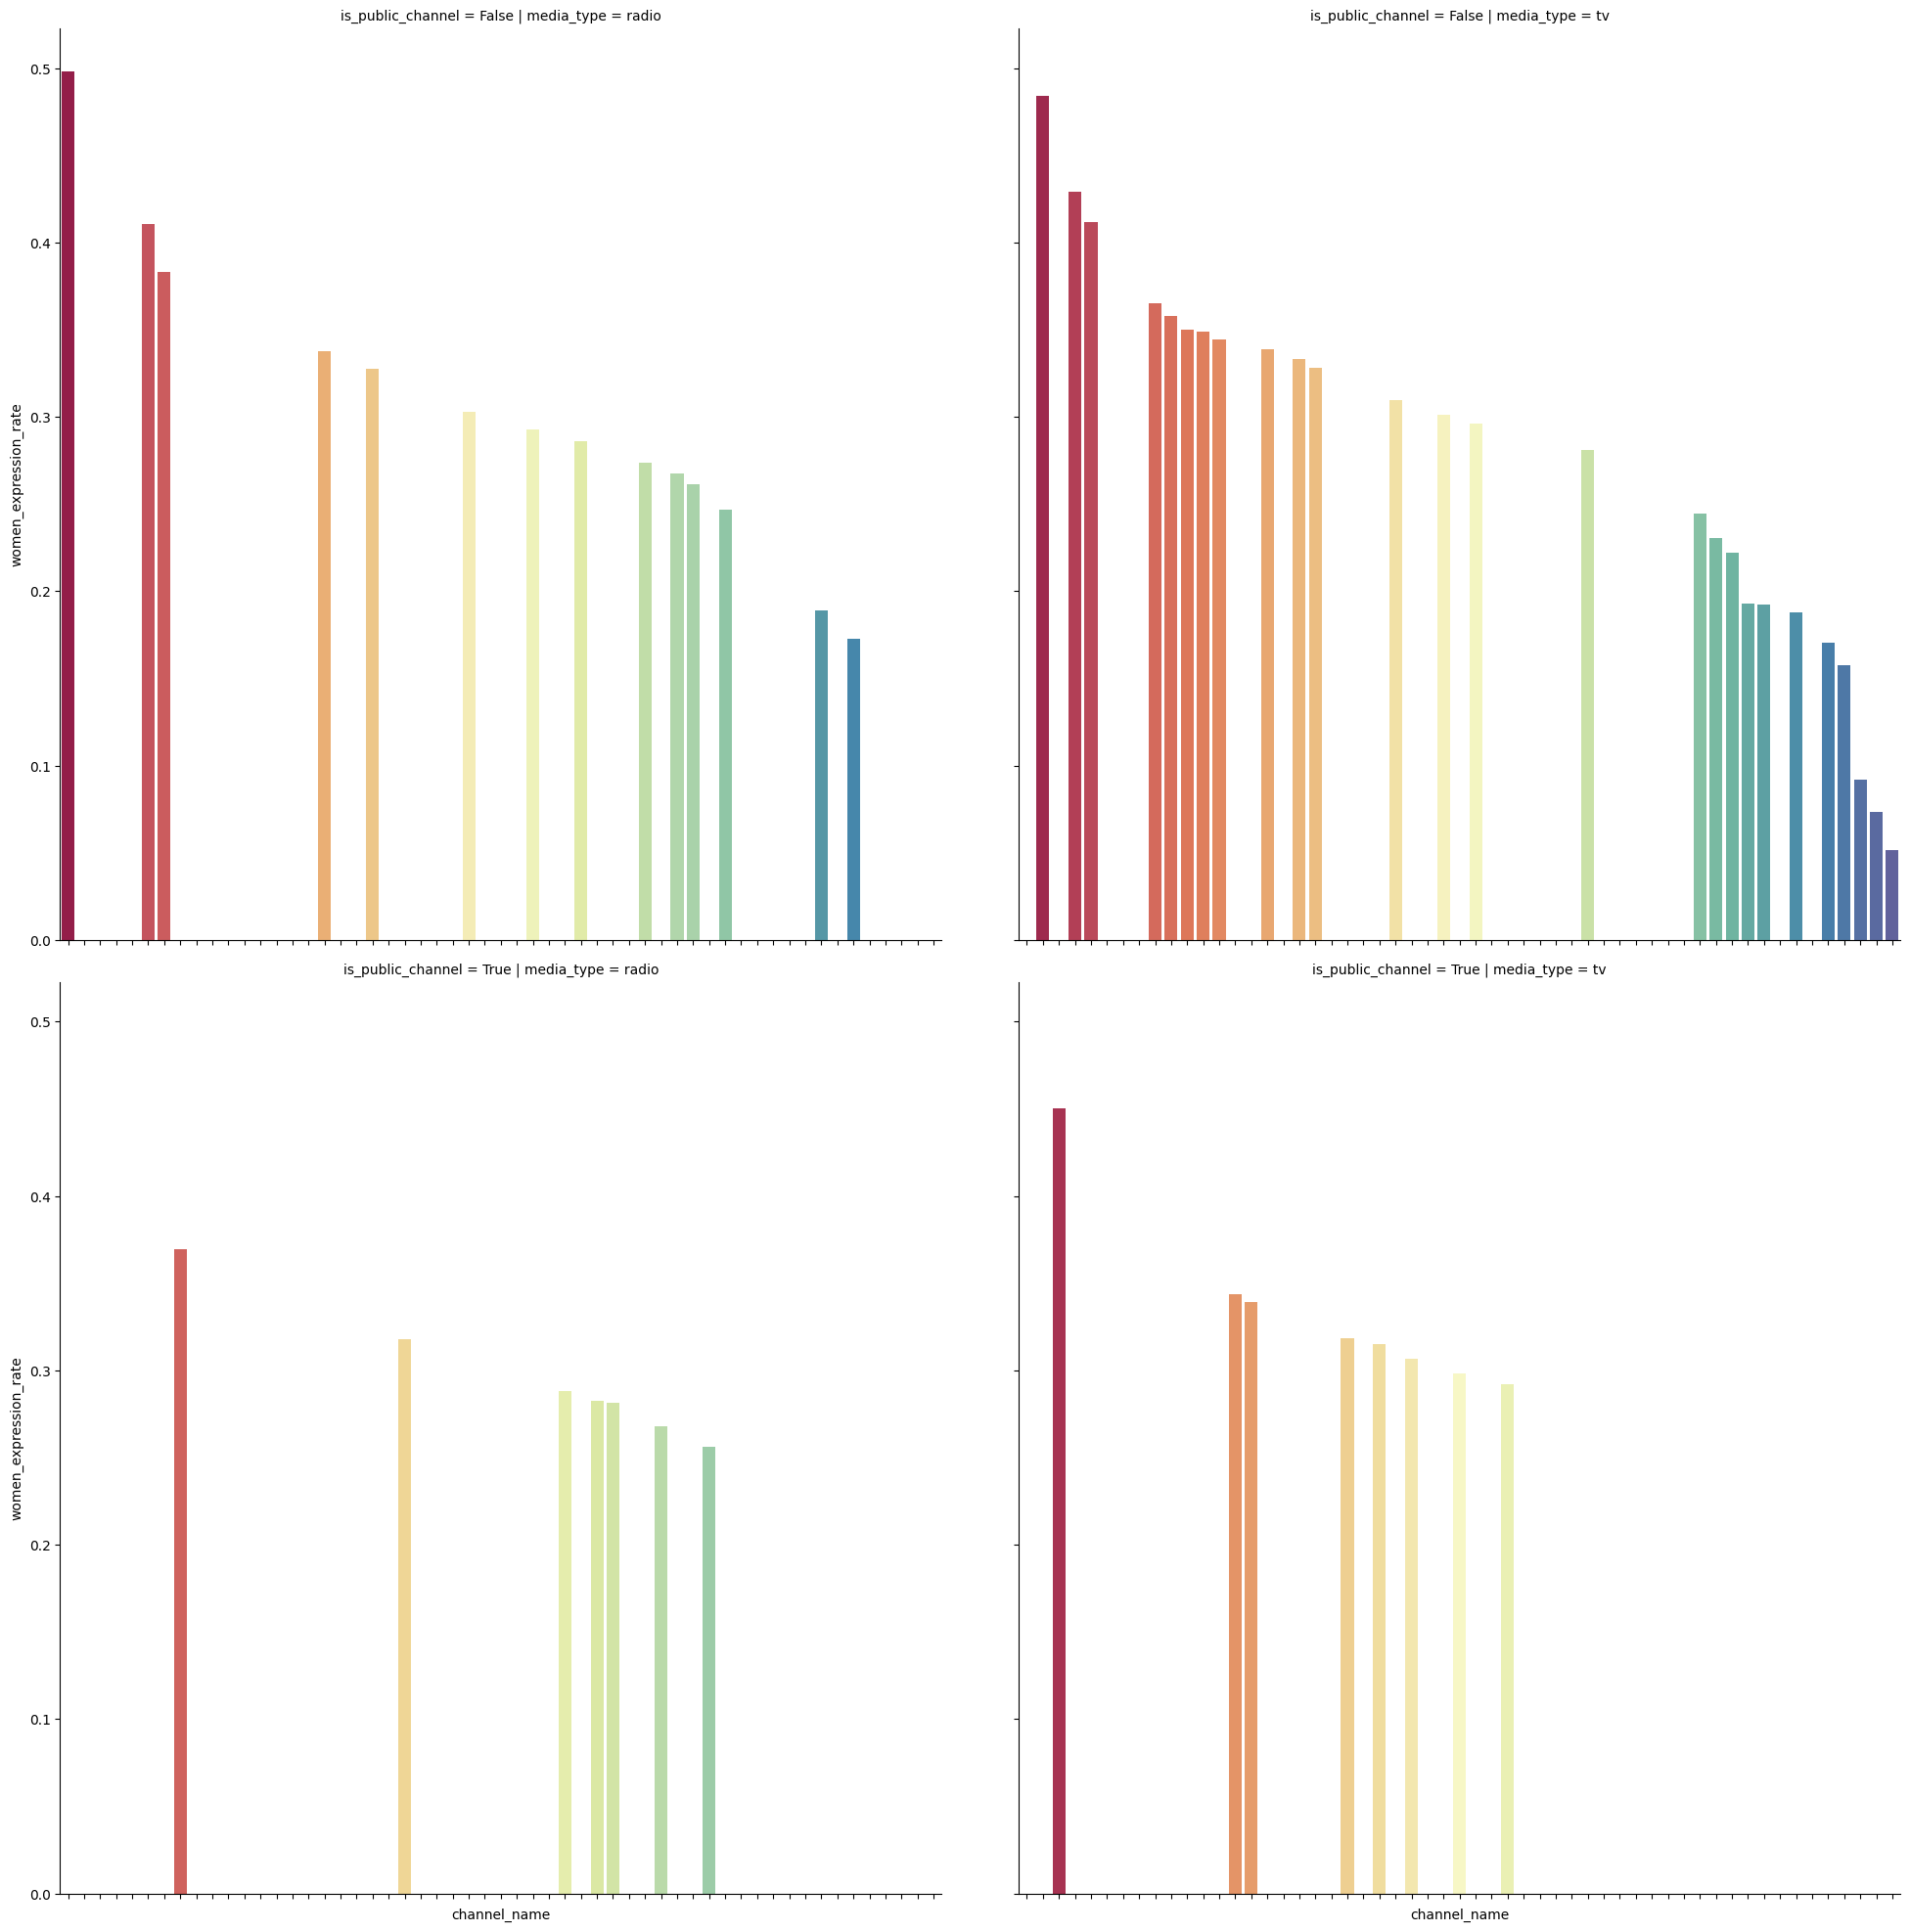

In [21]:
# Visualisation graphique, classement des chaînes

sns.catplot(
    x="channel_name",
    y="women_expression_rate",
    data=df_channel_sorted,
    col="media_type",
    row="is_public_channel",
    kind="bar",
    height=10,
    palette="Spectral",
).set_xticklabels(rotation=90)
plt.show()

### Étude de l'évolution temporelle du temps de parole des femmes à différents niveaux 

#### Évolution temporelle du taux d'expression des femmes global (radio et TV confondus)

Quelle est l'évolution annuelle du taux de parole des femmes entre 1995 et 2019 ? 

In [22]:
# On groupe par année

df_years = (
    df_stats.groupby(
        [
            "year",
        ]
    )
    .agg(
        {
            "male_duration": "sum",
            "female_duration": "sum",
            "music_duration": "sum",
            "hour": "count",
        }
    )
    .reset_index()
    .rename(
        columns={
            "hour": "nb_hours_analyzed",
        }
    )
)

In [23]:
# Ratio par année
df_years = ratio(df_years)

In [24]:
df_years_sorted = df_years.sort_values(
    by="women_expression_rate", ascending=True
).reset_index(drop=True)
df_years_sorted.head(5)

,year,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate
0,1995,14940812.22,4751615.94,9391865.54,8382,0.241292,0.758708,0.322919,0.677081
1,1997,15472833.74,4931093.32,8815351.56,8452,0.241674,0.758326,0.301696,0.698304
2,1998,15671692.18,5000068.86,8850580.16,8481,0.241879,0.758121,0.299793,0.700207
3,1996,15446184.18,5009805.82,9326393.68,8578,0.244907,0.755093,0.313151,0.686849
4,1999,15745646.60,5412489.94,9527409.92,8787,0.255811,0.744189,0.310485,0.689515


Entre 1995 et 2020, le taux d'expression des femmes dans les médias (tout média confondu) croit dans l'ensemble sur la période. 

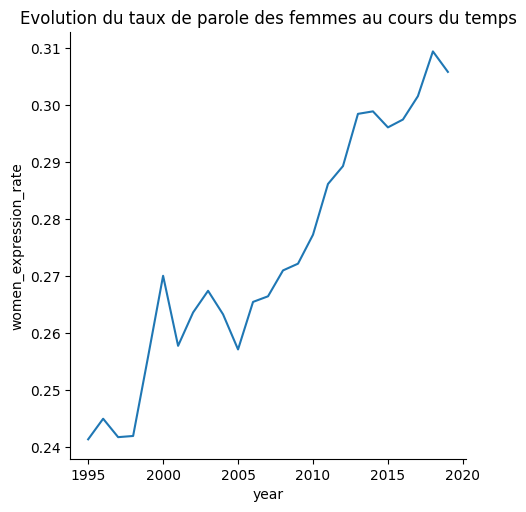

In [25]:
# visualisation :

sns.relplot(
    x="year",
    y="women_expression_rate",
    data=df_years_sorted,
    kind="line",
)

plt.title("Evolution du taux de parole des femmes au cours du temps")
plt.show()

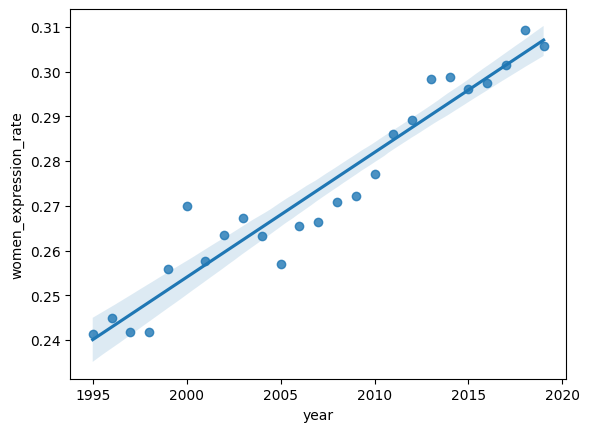

In [26]:
# Régression :

sns.regplot(
    x="year",
    y="women_expression_rate",
    data=df_years_sorted,
)
plt.show()

### Sur quelles thématiques les femmes parlent-elles le plus ?  

#### Les radio musicales sont-elles plus féminines ou masculine en terme de temps de parole ? 

In [27]:
df_radio = df_stats[df_stats["media_type"] == "radio"].copy()

# en regardant une station radio musicale on constate que le taux de musique est proche de 0.7
# création d'une indicatrice indiquant si la station radio est musicale ou non.
# le critère est d'avoir un taux de musique > 0.7
# on ajoute musique rate à la base de donnée df_radio

df_radio["music_rate"] = df_radio["music_duration"] / (
    df_radio["female_duration"] + df_radio["male_duration"] + df_radio["music_duration"]
)

df_radio["musical_channel"] = df_radio["music_rate"] > 0.7
df_radio.head(5)

,media_type,channel_code,channel_name,is_public_channel,date,week_day,school_holiday_zones,civil_holyday,hour,male_duration,female_duration,music_duration,year,month,music_rate,musical_channel
0,radio,CHE,Chérie FM,False,2001-01-01,Monday,ABC,True,5,224.34,191.86,3180.34,2001,1,0.884278,True
1,radio,CHE,Chérie FM,False,2001-01-01,Monday,ABC,True,11,160.68,137.90,3297.08,2001,1,0.916961,True
2,radio,CHE,Chérie FM,False,2001-01-01,Monday,ABC,True,13,124.20,168.28,3303.96,2001,1,0.918675,True
3,radio,CHE,Chérie FM,False,2001-01-01,Monday,ABC,True,18,251.20,185.58,3156.34,2001,1,0.878440,True
4,radio,CHE,Chérie FM,False,2001-01-02,Tuesday,ABC,False,6,550.76,223.60,2818.50,2001,1,0.784473,True


In [28]:
# Chérie FM par exemple est considérée comme une station radio musicale
df_radio.iloc[0, -1]

np.True_

In [29]:
df_radio_musical_channel = (
    df_radio.groupby(
        [
            "musical_channel",
        ]
    )
    .agg(
        {
            "female_duration": "sum",
            "male_duration": "sum",
            "music_duration": "sum",
            "hour": "count",
        }
    )
    .reset_index()
    .rename(
        columns={
            "hour": "nb_hours_analyzed",
        }
    )
)
df_radio_musical_channel

,musical_channel,female_duration,male_duration,music_duration,nb_hours_analyzed
0,False,2.917634e+08,7.751182e+08,2.736311e+08,378430
1,True,4.464907e+07,7.963337e+07,7.948430e+08,258392


In [30]:
# recréeation du women_expression_rate
df_radio_musical_channel["women_expression_rate"] = df_radio_musical_channel["female_duration"] / (df_radio_musical_channel["female_duration"] + df_radio_musical_channel["male_duration"])
df_radio_musical_channel

,musical_channel,female_duration,male_duration,music_duration,nb_hours_analyzed,women_expression_rate
0,False,2.917634e+08,7.751182e+08,2.736311e+08,378430,0.273473
1,True,4.464907e+07,7.963337e+07,7.948430e+08,258392,0.359255


On constate que les femmes parlent un peu plus sur les chaînes musicales que sur les autres chaines.

In [31]:
musical_channel = (
    ratio(
        df_radio_musical_channel.groupby(["musical_channel"])
        .agg(
            {
                "female_duration": "sum",
                "male_duration": "sum",
                "music_duration":"sum",
                "nb_hours_analyzed": "count",
            }
        )
        .reset_index()
    )
    .set_index(["musical_channel"])[["women_expression_rate", "men_expression_rate"]]
)
musical_channel

,women_expression_rate,men_expression_rate
musical_channel,,
False,0.273473,0.726527
True,0.359255,0.640745


Text(0.5, 1.0, "Taux d'expression masculin et féminin selon le type de chaîne (musical-True ou non-False)")

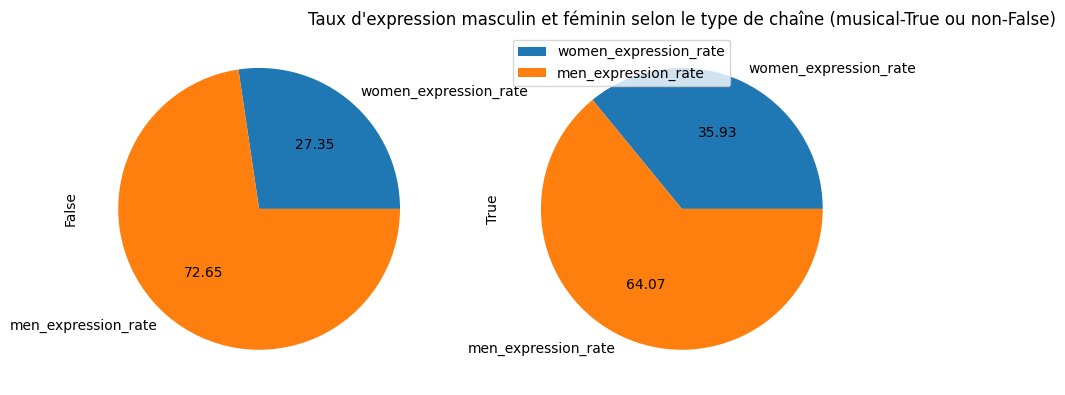

In [32]:
musical_channel.T.plot.pie(subplots=True, legend=False, figsize=(10, 100), autopct="%.2f")
plt.legend( loc = 'best' )
plt.title("Taux d'expression masculin et féminin selon le type de chaîne (musical-True ou non-False)")

On voit graphiquement que sur les chaînes dites musicales, les femmes parlent un peu plus que sur les autres.

#### Etude du taux d'expression des femmes selon le type des chaînes de télévisions

On s'intéresse maintenant au taux d'expression des femmes sur les chaînes de télévision selon le genre des chaînes. Pour cela, on récupère les données depuis un tableau de la page Wikipédia "Liste des chaînes de télévision en France" qui résument les informations nécessaires. 

In [33]:
# enregistrement de l'url de la page d'intérêt.
url_channel="https://fr.wikipedia.org/wiki/Liste_des_cha%C3%AEnes_de_t%C3%A9l%C3%A9vision_en_France"
from urllib import request
request_text = request.urlopen(url_channel).read()

In [34]:
# Utilisation de BeautifulSoup 

page = bs4.BeautifulSoup(request_text, "lxml")
# Récupération du tableau utile sur la page en code html.
table = page.find('table', {'class' : 'wikitable sortable'})
# On isole le corps du tableau.
channel_type=pd.read_html(table.prettify(), flavor="lxml")
df_channel_type=channel_type[0].drop(columns=["Logo"])
df_channel_type.head()

,Nom,Genre,Propriétaire
0,6ter,Généraliste,Groupe M6
1,13ème Rue,Cinéma Série,NBC Universal Global Networks France
2,AB1,Divertissement,Mediawan Thematics
3,Action,Cinéma,Mediawan Thematics
4,Animaux,Documentaire,Mediawan Thematics


In [35]:
data_channel_type = df_channel_type[['Nom','Genre']]
data_channel_type = data_channel_type.rename(columns = {'Nom':'channel_name','Genre':'channel_type'})
data_channel_type.head()

,channel_name,channel_type
0,6ter,Généraliste
1,13ème Rue,Cinéma Série
2,AB1,Divertissement
3,Action,Cinéma
4,Animaux,Documentaire


In [36]:
df_tv = df_stats[df_stats["media_type"] == "tv"].copy()
df_tv.head(5)

,media_type,channel_code,channel_name,is_public_channel,date,week_day,school_holiday_zones,civil_holyday,hour,male_duration,female_duration,music_duration,year,month
636822,tv,ART,ARTE,True,2010-01-01,Friday,ABC,True,12,829.06,371.28,2056.80,2010,1
636823,tv,ART,ARTE,True,2010-01-01,Friday,ABC,True,14,148.42,68.56,2993.40,2010,1
636824,tv,ART,ARTE,True,2010-01-01,Friday,ABC,True,18,1722.84,307.90,1238.96,2010,1
636825,tv,ART,ARTE,True,2010-01-01,Friday,ABC,True,21,2714.88,329.62,286.16,2010,1
636826,tv,ART,ARTE,True,2010-01-02,Saturday,ABC,False,11,1254.78,1243.14,1070.86,2010,1


In [37]:
df_tv.loc[df_tv['channel_name'] == 'I-Télé/CNews', 'channel_name'] = 'CNews'
df_tv_type = df_tv.merge(data_channel_type,how='inner')
df_tv_type.sample(5)

,media_type,channel_code,channel_name,is_public_channel,date,week_day,school_holiday_zones,civil_holyday,hour,male_duration,female_duration,music_duration,year,month,channel_type
157733,tv,LCI,LCI,False,2017-10-12,Thursday,NaN,False,15,2006.08,1128.82,360.16,2017,10,Information
84851,tv,FR2,France 2,True,2012-10-20,Saturday,NaN,False,11,1327.68,1206.10,867.08,2012,10,Généraliste
113720,tv,FR5,France 5,True,2010-10-20,Wednesday,NaN,False,19,2239.76,1054.12,252.22,2010,10,Documentaire
271714,tv,W9,W9,False,2012-04-20,Friday,AC,False,13,1087.50,1329.40,1045.82,2012,4,Généraliste
231312,tv,BRE,TV Breizh,False,2014-08-03,Sunday,ABC,False,20,2231.58,650.10,633.04,2014,8,Généraliste


In [38]:
df_tv_type['channel_type'].unique()

array(['Documentaire', 'Information', 'Généraliste', 'Sport',
       'Divertissement'], dtype=object)

In [39]:
# On recrée le women_expression_rate
df_tv_type["women_expression_rate"] = df_tv_type[
    "female_duration"
] / (
    df_tv_type["female_duration"]
    + df_tv_type["male_duration"]
)
df_tv_type.sample(10)

,media_type,channel_code,channel_name,is_public_channel,date,week_day,school_holiday_zones,civil_holyday,hour,male_duration,female_duration,music_duration,year,month,channel_type,women_expression_rate
67039,tv,COM,Comédie+,False,2015-08-22,Saturday,ABC,False,14,1847.52,1227.56,386.94,2015,8,Divertissement,0.399196
153080,tv,LCI,LCI,False,2014-12-21,Sunday,ABC,False,21,2547.04,617.00,373.54,2014,12,Information,0.195004
153438,tv,LCI,LCI,False,2015-03-15,Sunday,NaN,False,21,887.00,2151.98,447.70,2015,3,Information,0.708126
65245,tv,COM,Comédie+,False,2013-09-27,Friday,NaN,False,23,1472.00,489.58,1395.86,2013,9,Divertissement,0.249585
192181,tv,N12,NRJ 12,False,2018-10-29,Monday,ABC,False,19,1241.52,983.86,1324.10,2018,10,Généraliste,0.442109
74944,tv,ENW,Euronews,False,2014-03-01,Saturday,ABC,False,22,2031.06,865.24,631.86,2014,3,Information,0.298740
204551,tv,PLA,Planète+,False,2012-01-19,Thursday,NaN,False,18,1963.90,524.82,1006.64,2012,1,Documentaire,0.210879
256793,tv,TEV,Téva,False,2012-09-28,Friday,NaN,False,15,1441.82,637.68,1184.92,2012,9,Généraliste,0.306651
34280,tv,C+,Canal+,False,2015-05-15,Friday,NaN,False,22,1413.86,241.60,1839.94,2015,5,Généraliste,0.145941
145975,tv,LCI,LCI,False,2010-08-30,Monday,ABC,False,12,2397.98,833.02,286.92,2010,8,Information,0.257821


In [40]:
df_tv_channel_type = (
    df_tv_type.groupby(
        [
            "channel_type",
        ]
    )
    .agg(
        {
            "female_duration": "sum",
            "male_duration": "sum",
            "hour": "count",
        }
    )
    .reset_index()
    .rename(
    columns={
        "hour": "nb_hours_analyzed",
    }
    )
    )
df_tv_channel_type

,channel_type,female_duration,male_duration,nb_hours_analyzed
0,Divertissement,7.181305e+06,1.706515e+07,9321
1,Documentaire,3.293786e+07,9.095601e+07,43915
2,Généraliste,1.455668e+08,2.783513e+08,163856
3,Information,6.143643e+07,1.171176e+08,57546
4,Sport,1.489295e+06,2.739133e+07,9331


In [41]:
# On recrée le women_expression_rate
df_tv_channel_type["women_expression_rate"] = df_tv_channel_type[
    "female_duration"
] / (
    df_tv_channel_type["female_duration"]
    + df_tv_channel_type["male_duration"]
)
df_tv_channel_type

,channel_type,female_duration,male_duration,nb_hours_analyzed,women_expression_rate
0,Divertissement,7.181305e+06,1.706515e+07,9321,0.296180
1,Documentaire,3.293786e+07,9.095601e+07,43915,0.265855
2,Généraliste,1.455668e+08,2.783513e+08,163856,0.343384
3,Information,6.143643e+07,1.171176e+08,57546,0.344078
4,Sport,1.489295e+06,2.739133e+07,9331,0.051567


Le taux d'expression des femmes est très faibles sur les chaînes de sports (5%) ainsi que sur la châine 'Planète +' (17%), qui est la seule chaîne de l'échantillon classée dans la catégorie 'Découverte. Sur les chaînes classées dans les catégories 'Généraliste' et 'Information', les femmes s'expriment autant que dans la moyenne générale de l'échantillon (33-34%).

In [42]:
df_tv_by_channel_type = ratio(
    df_tv_type.groupby(["channel_type", "channel_name"])
    .agg(
        {
            "female_duration": "sum",
            "male_duration": "sum",
            "music_duration": "sum",
            "hour": "sum",
        }
    )
    .reset_index()
    .rename(
    columns={
        "hour": "nb_hours_analyzed"
    })
).set_index(["channel_type", "channel_name"])

df_tv_by_channel_type

female_duration  male_duration  \
channel_type   channel_name                                       
Divertissement Comédie+               7181305.42    17065148.18   
Documentaire   Animaux                8839519.94    16405062.44   
               France 5              14853545.10    32261392.06   
               Planète+               4289691.76    20838486.56   
               Toute l'Histoire       4955104.28    21451065.30   
Généraliste    Canal+                 9214530.34    32240935.84   
               Chérie 25             12574077.52    16743406.78   
               France 2              15656992.16    29905964.84   
               France 3              14135135.70    30227058.50   
               M6                    17326081.44    24781593.00   
               NRJ 12                13169097.20    26987116.38   
               Paris Première         5395608.14    17989166.56   
               TF1                   15587736.14    27122817.02   
               TV Breizh              6490266.08    14466762.00   
               TV5 Monde              8143047.42    18401296.54   
               Téva                  15667061.64    16710698.24   
               W9                    12207169.20    22774444.70   
Information    BFM TV                18186657.80    32654302.64   
               CNews                 17568674.86    33484681.92   
               Euronews               8635260.26    16865658.36   
               LCI                   17045837.06    34112966.28   
Sport          Canal+ Sport           1489294.84    27391333.24   

                                 music_duration  nb_hours_analyzed  \
channel_type   channel_name                                          
Divertissement Comédie+              7473237.24             153434   
Documentaire   Animaux               6956001.72             151888   
               France 5              9753599.62             269150   
               Planète+              6661739.58             150074   
               Toute l'Histoire      5690085.12             153695   
Généraliste    Canal+               13751777.40             265777   
               Chérie 25             9138546.28             182226   
               France 2             10021281.52             265553   
               France 3             10565794.18             263911   
               M6                   13899142.60             267117   
               NRJ 12               16469079.78             269259   
               Paris Première        8597494.36             153441   
               TF1                  13464969.82             267753   
               TV Breizh             7361320.60             135523   
               TV5 Monde             5494102.84             151272   
               Téva                 13247179.58             218436   
               W9                   20849991.04             264968   
Information    BFM TV                5313832.36             264667   
               CNews                 5780212.02             268077   
               Euronews              6277099.04             149890   
               LCI                   5196714.98             265803   
Sport          Canal+ Sport          3977827.34             153675   

                                 women_expression_rate  men_expression_rate  \
channel_type   channel_name                                                   
Divertissement Comédie+                       0.296180             0.703820   
Documentaire   Animaux                        0.350155             0.649845   
               France 5                       0.315262             0.684738   
               Planète+                       0.170712             0.829288   
               Toute l'Histoire               0.187649             0.812351   
Généraliste    Canal+                         0.222275             0.777725   
               Chérie 25                      0.428893             0.571107   
               France 2         

In [43]:
channel_type = (
    ratio(
        df_tv_by_channel_type.groupby(["channel_type"])
        .agg(
            {
                "female_duration": "sum",
                "male_duration": "sum",
                "music_duration": "sum",
                "nb_hours_analyzed": "count",
            }
        )
        .reset_index()
    )
    .set_index(["channel_type"])[["women_expression_rate", "men_expression_rate"]]
)
channel_type

,women_expression_rate,men_expression_rate
channel_type,,
Divertissement,0.296180,0.703820
Documentaire,0.265855,0.734145
Généraliste,0.343384,0.656616
Information,0.344078,0.655922
Sport,0.051567,0.948433


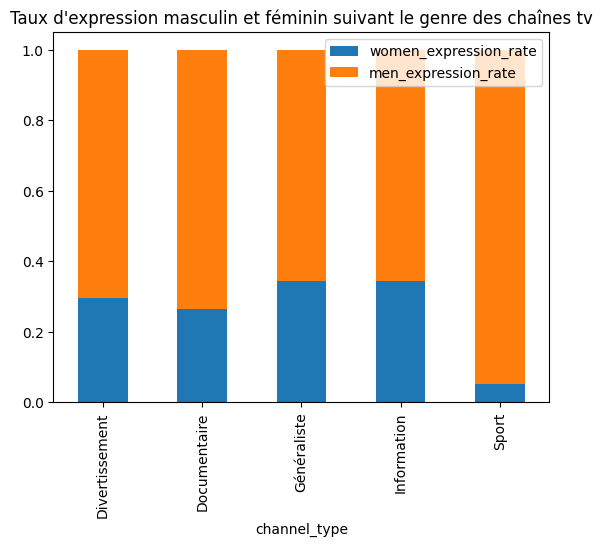

In [44]:
channel_type.plot.bar(stacked=True)
plt.title("Taux d'expression masculin et féminin suivant le genre des chaînes tv")
plt.show()

In [45]:
# création d'un nouveau dataframe contenant seulement les chaînes appartenant à France Télévions
df_tv_type['France Télévisions'] = df_tv_type['channel_name'].str.contains('France')
df_tv_type
df_france_tv = df_tv_type[df_tv_type['France Télévisions'] == True]
df_france_tv = df_france_tv[df_france_tv['year'] >= 2016]

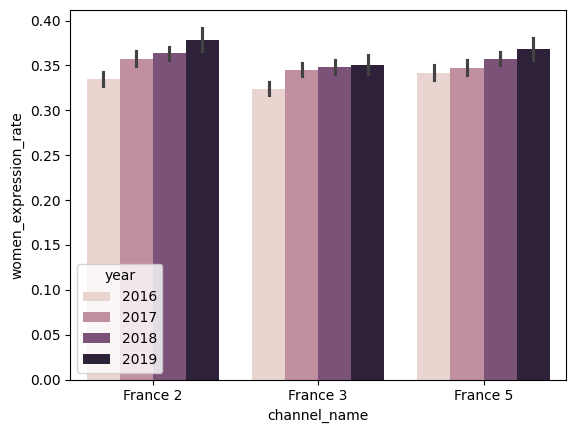

In [46]:
sns.barplot(x="channel_name", y="women_expression_rate",hue='year', data=df_france_tv)
plt.show()

Le taux d'expression des femmes a très légèrement augmenté entre 2016 et 2019 pour les chaînes appartenant au groupe France Télévisions. Cependant, ce taux reste très loin de la parité hommes-femmes. 

### Etude de la relation entre le taux d'expression des femmes et le taux d'audience des chaînes télévisées

In [47]:
audiences = pd.read_excel(
    "data/audiences_tv.xlsx", 
    sheet_name = "PartdAudience", 
    skiprows=6, 
    nrows=35
)

audiences = audiences.rename(columns={audiences.columns[0]: "year"})

flattened_audiences = audiences.melt(id_vars=["year"], var_name="channel_name", value_name="audience")

flattened_audiences["audience"] = pd.to_numeric(flattened_audiences["audience"], errors="coerce")

df_audience = flattened_audiences.dropna(subset=["audience"])
df_audience.head(5)

,year,channel_name,audience
0,1989,TF1,41.0
1,1990,TF1,41.9
2,1991,TF1,42.1
3,1992,TF1,41.0
4,1993,TF1,41.0


In [48]:
# Ensuite, on merge cette nouvelle base avec notre base de données sur les chaînes tv
grouped = df_year_level.groupby(df_year_level.media_type)
df_tv = grouped.get_group("tv").reset_index(drop = True)
df_tv_audience=df_tv.merge(df_audience,how='inner')
df_tv_audience['channel_name'].unique() #15 chaînes restantes
df_tv_audience.sample(5)

,media_type,channel_code,channel_name,is_public_channel,year,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate,audience
63,tv,W9,W9,False,2012,2289710.58,1086977.44,2409293.18,1666,0.321906,0.678094,0.416402,0.583598,3.2
20,tv,FR2,France 2,True,2013,3023424.60,1619884.96,995125.78,1640,0.348864,0.651136,0.176490,0.823510,14.0
53,tv,TF1,TF1,False,2012,2810126.30,1576498.04,1539282.92,1725,0.359388,0.640612,0.259755,0.740245,22.7
52,tv,TF1,TF1,False,2011,2755459.58,1461290.42,1490327.48,1661,0.346544,0.653456,0.261137,0.738863,23.7
42,tv,FR5,France 5,True,2015,3291218.50,1541183.54,845654.50,1626,0.318927,0.681073,0.148934,0.851066,3.4


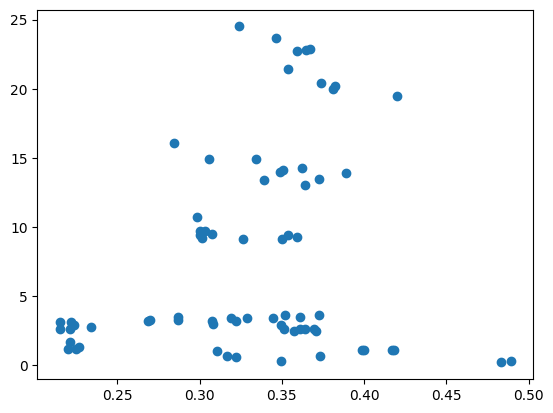

In [49]:
plt.scatter(df_tv_audience['women_expression_rate'],df_tv_audience['audience'])
plt.show()

Il ne semble pas y avoir de corrélation entre le taux d'audience des chaînes et le taux d'expression des femmes sur ces chaînes.

In [50]:
# statistiques decriptives
df_tv_audience['audience'].describe()

count    71.000000
mean      7.716901
std       7.316459
min       0.200000
25%       2.600000
50%       3.400000
75%      13.450000
max      24.500000
Name: audience, dtype: float64

In [51]:
#Grâce aux statistiques descriptives, on définit un seuil à partir duquel la chaîne est une chaîne à forte audience
# on choisit le 3ème quartile
# on fait de même pour définir des chaînes à faible audience et choix de la médiane comme seuil
df_tv_audience['high_audience']=df_tv_audience['audience']>9.4
df_tv_audience['low_audience']=df_tv_audience['audience']<2.8
df_tv_audience.head()

,media_type,channel_code,channel_name,is_public_channel,year,male_duration,female_duration,music_duration,nb_hours_analyzed,women_expression_rate,men_expression_rate,music_rate,speech_rate,audience,high_audience,low_audience
0,tv,C+,Canal+,False,2010,3317801.08,909338.40,1480734.56,1661,0.215119,0.784881,0.259420,0.740580,3.1,False,False
1,tv,C+,Canal+,False,2011,3462849.62,985729.76,1592082.22,1759,0.221583,0.778417,0.263561,0.736439,3.1,False,False
2,tv,C+,Canal+,False,2012,3337759.30,960719.22,1475736.20,1678,0.223502,0.776498,0.255573,0.744427,2.9,False,False
3,tv,C+,Canal+,False,2013,3417584.40,1044860.86,1402977.64,1700,0.234145,0.765855,0.239195,0.760805,2.8,False,False
4,tv,C+,Canal+,False,2014,3357826.58,953915.78,1246158.38,1608,0.221237,0.778763,0.224214,0.775786,2.6,False,True


In [52]:
# Exercice supplémentaire: classement des chaines par audience
df_tv_audience.loc[df_tv_audience['audience']>9.4,['channel_name']]
#On obtient : France 2, France 3, M6 et TF1

,channel_name
17,France 2
18,France 2
19,France 2
20,France 2
21,France 2
22,France 2
23,France 2
24,France 2
25,France 2
26,France 2


# Modélisation 

On dépasse désormais le descriptif et l'analyse. On choisit de prédire l'évolution mensuelle du _women expression rate_ pour une chaine donnée et pour un nombre de mois après la date de la dernière information certaine. Pour cela on utilise le package **Prophet**.

Prophet est une une bibliothèque (Python et R) de prévision de séries chronologiques basée sur un modèle additif où les tendances non linéaires sont ajustées à la saisonnalité annuelle notamment. 

L'input est une base de donnée à deux colonnes : `ds` et `y`. `y` (target) est la colonne numérique sur laquelle on veut obtenir le forecast. `ds` (datastamp column) est la colonne qui représente une date ou un instant.

In [53]:
# TOP 5 en nombre d'heures analysées pour sélectionner les chaines sur lesquelles appliquer le forecast
df_stats.groupby(["channel_name"]).agg({"hour": "count"}).reset_index().sort_values(
    by="hour", ascending=False
).head(5)

,channel_name,hour
18,France Culture,47206
21,France Musique,46526
20,France Inter,44438
19,France Info,44259
38,RFI,33192


## Préparation des données pour construire un modèle

In [54]:
df_forecast = df_stats.copy()
df_forecast["date"] = pd.to_datetime(df_forecast["date"])

# On arrondit les dates au premier jour du mois
df_forecast["date"] = df_forecast["date"].dt.to_period('M').dt.to_timestamp()
df_forecast_grouped = (
    df_forecast.groupby(
        [
            "media_type",
            "channel_name",
            "is_public_channel",
            "date",
        ]
    )
    .agg(
        {
            "male_duration": "sum",
            "female_duration": "sum",
            "music_duration": "sum",
        }
    )
    .reset_index()
)

# On applique la fonction ratio 
df_forecast_grouped = ratio(df_forecast_grouped)

# Simplification de la base de données : on ne garde que les trois colonnes date, channel_name et women_expression_rate
df_forecast_grouped = df_forecast_grouped[
    ["date", "channel_name", "women_expression_rate"]
].copy()

df_forecast_grouped

,date,channel_name,women_expression_rate
0,2001-01-01,Chérie FM,0.510067
1,2001-08-01,Chérie FM,0.443730
2,2001-09-01,Chérie FM,0.436863
3,2002-04-01,Chérie FM,0.475674
4,2002-05-01,Chérie FM,0.500444
...,...,...,...
7820,2018-10-01,W9,0.325651
7821,2018-11-01,W9,0.323991
7822,2018-12-01,W9,0.355715
7823,2019-01-01,W9,0.357834


## Modèle : _time series_ forecasting avec Prophet

In [55]:
def forecast(channel_name, periods=12):
    """
    Prend en input le nom d'une chaîne
    et le nombre de périodes (mois) sur lesquelles 
    on veut prédire et affiche la prévision
    """
    # On filtre la base de données sur la chaîne passée en argument de la fonction.
    df_fit = df_forecast_grouped[
        df_forecast_grouped["channel_name"] == channel_name
    ].copy() 
    df_fit = df_fit[["date", "women_expression_rate"]].copy()
    # On renomme les colonnes de df_fit conformément aux attentes du modèle.
    df_fit.columns = [
        "ds",
        "y",
    ]

    try:
        # On initialise Prophet.
        m = Prophet(weekly_seasonality=False, daily_seasonality=False)
        
        # On ajoute les jours fériés français. 
        # Si le modèle pense qu’il est pertinent de les prendre en compte dans l'analyse, il le fera. 
        m.add_country_holidays(country_name="FR")
        
        # On applique le modèle à df_fit.
        m.fit(df_fit)
    
    except ValueError:
        print("Erreur : Chaîne non trouvée")
        return

    # On crée un dataframe future contenant les dates sur lesquelles les prévisions seront faites.
    future = m.make_future_dataframe(periods=periods, freq="MS")

    # On réalise la prédiction
    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)

21:07:42 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing


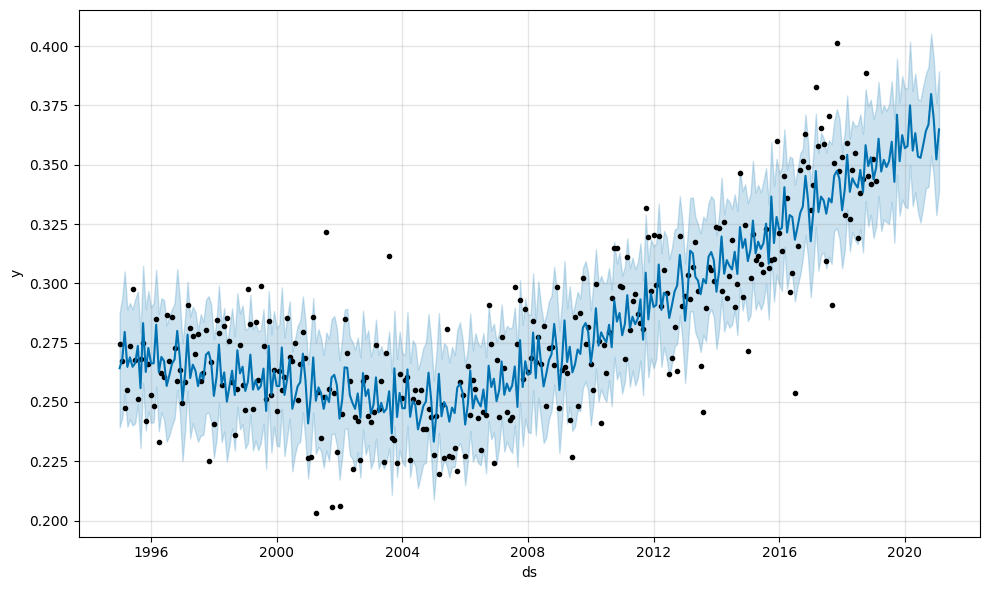

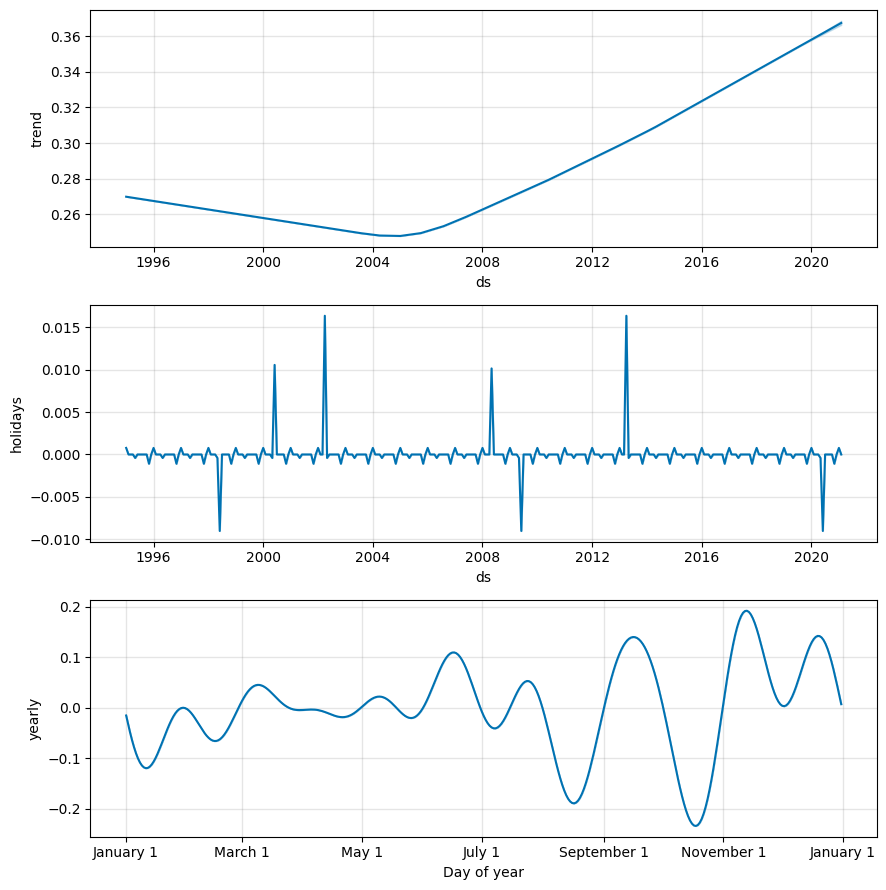

In [56]:
forecast("France Culture", periods=24)

France Culture est choisie car la chaine fait partie du TOP 5 des chaînes les plus analysées. 

Forecast : les points noirs correspondent aux valeurs réelles du women_expression_rate pour la chaine France Culture. La courbe bleue foncée correpond au forecast, tous les composants (trend, saisonalité, résidus) de la série temporelle confondus. La qualité du forecast a l'air plutôt bonne: seuls quelques points sont en dehors de la zone bleues claires qui représente l'intervelle de confiance. 

Tendance : La tendance est décroissante de 1995 à 2005 avant de devenir fortement croissante à partir de 2005.

Les vacances scolaires : Prophet prend en compte également les jours fériés. On constate que les effets des vacances scolaires sont minimes. 

Saisonalité : On a introduit une saisonalité annuelle, sinon le forecast semble moins bon. Plus de valeurs réelle de y sont à l'extérieur de l'intervalle bleu.

21:07:43 - cmdstanpy - INFO - Chain [1] start processing
21:07:43 - cmdstanpy - INFO - Chain [1] done processing


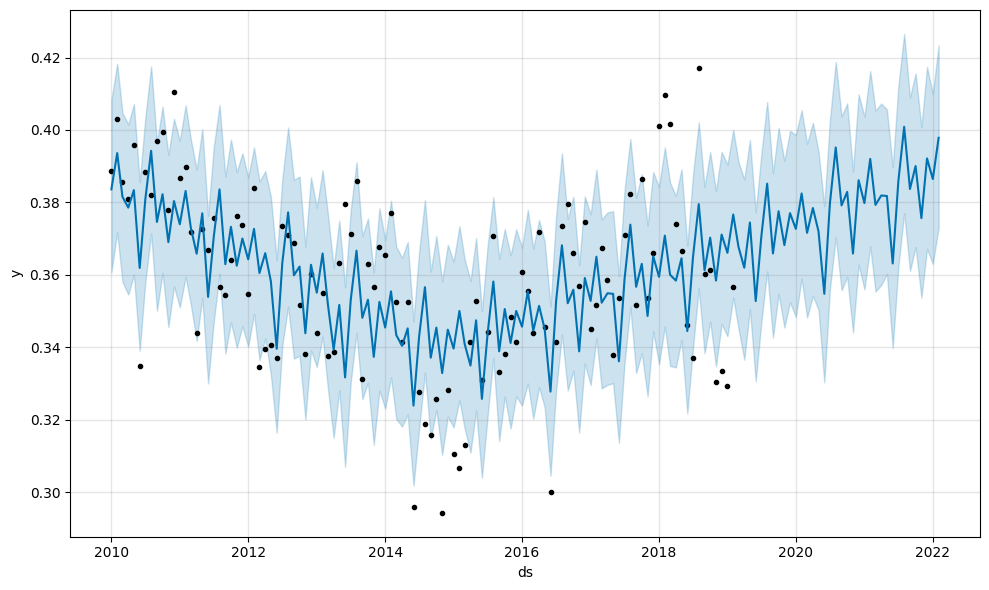

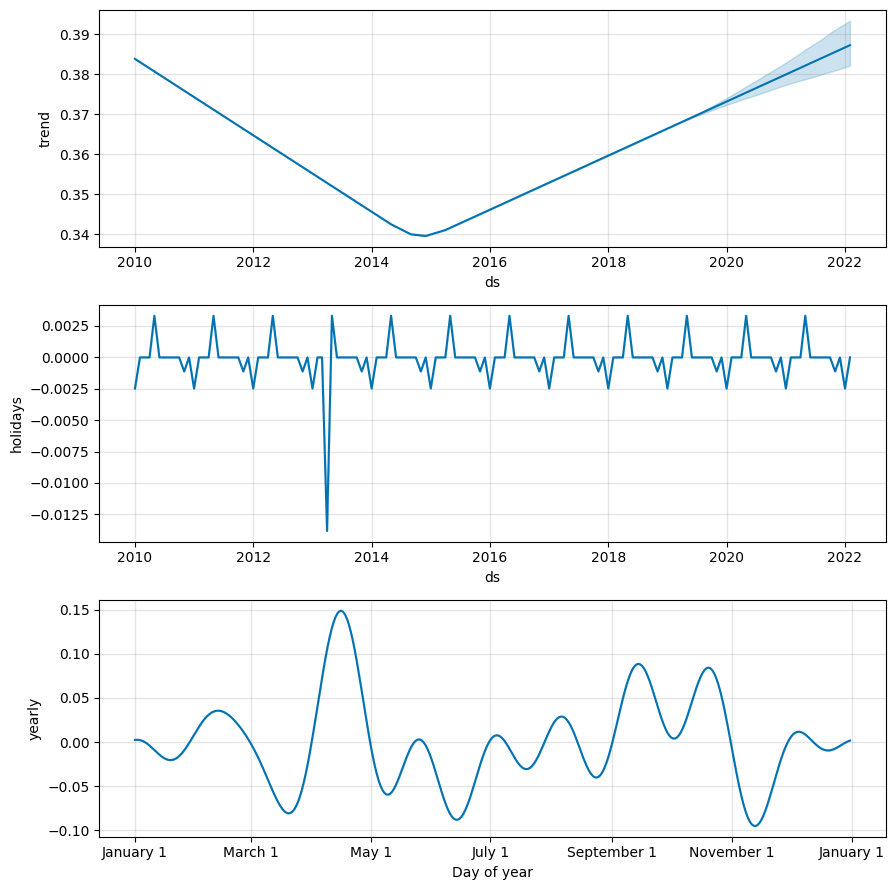

In [57]:
forecast("BFM TV", periods=36)

## Évaluation de la qualité du modèle : évaluation de la performance des prédictions

Il s'agit d'une "cross validation procedure". Prophet comprend une fonctionnalité d'évaluation de la qualité du modèle en mesurant l'erreur de prévision à l'aide de données historiques. Cela se fait en sélectionnant des points de coupure dans l'histoire, et pour chacun d'eux, en ajustant le modèle en utilisant des données uniquement jusqu'à ce point de coupure. On peut alors comparer les valeurs prévues aux valeurs réelles.

La sortie de la validation croisée est un cadre de données avec les valeurs réelles y et les valeurs de prévision hors échantillon $\hat{y}$, à chaque date de prévision simulée et pour chaque date limite. En particulier, une prévision est faite pour chaque point observé entre la date limite et la date limite + l'horizon. La nouvelle dataframe obtenue s'appelle df_cv. Ce cadre de données peut ensuite être utilisé pour calculer les mesures d'erreur de $\hat{y}$ par rapport à y. Ces mesures d'erreurs sont résumées dans d_p. 

Dans les forecast précédents, le modèle utilise pour une chaine donnée, toutes les données disponibles dans df_forecast (copie df_stats) pour prédire le women_expression_rate sur deux nouvelles années qui ne sont pas disponibles dans les données : 2019 et 2020. Toutes les chaines n'ayant pas le même nombres de mois disponibles dans les données, pour réaliser l'évaluation du modèle, on prend un cas particulier : on choisit comme paramètres, dans cross validation, initial = '6 Y', period='1 Y', horizon = '2 Y'. Signification : on a regardé si le modèle est capable de faire des prédictions performantes sur deux ans en prenant les 6 années précédant le cutoff comme historique. Ce test est fait autant de fois possibles sur les données en déplacant le cutoff de un an à chaque fois. 

In [58]:
# Diagnostics 

def cross_validate(channel_name):
    """
    Prend en input le nom d'une chaîne
    et affiche deux dataframe comportant 
    des mesures de performance des prédictions
    """
    # On filtre la base de données sur la chaîne passée en argument de la fonction.
    df_fit = df_forecast_grouped[
        df_forecast_grouped["channel_name"] == channel_name
    ].copy() 
    df_fit = df_fit[["date", "women_expression_rate"]].copy()
    # On renomme les colonnes de df_fit conformément aux attentes du modèle.
    df_fit.columns = [
        "ds",
        "y",
    ]

    try:
        # On initialise Prophet.
        m = Prophet(weekly_seasonality=False, daily_seasonality=False)
        
        # On ajoute les jours fériés français. 
        # Si le modèle pense qu’il est pertinent de les prendre en compte dans l'analyse, il le fera. 
        m.add_country_holidays(country_name="FR")
        
        # On applique le modèle à df_fit.
        m.fit(df_fit)
    
    except ValueError:
        print("Erreur : Chaîne non trouvée")
        return
    
    df_cv = cross_validation(m, initial='312 W', period='52 W', horizon = '104 W')
    df_p = performance_metrics(df_cv)
    return df_cv, df_p

In [59]:
df_cv, df_p = cross_validate("France Culture")

21:07:44 - cmdstanpy - INFO - Chain [1] start processing
21:07:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/17 [00:00<?, ?it/s]

21:07:45 - cmdstanpy - INFO - Chain [1] start processing
21:07:45 - cmdstanpy - INFO - Chain [1] done processing
21:07:45 - cmdstanpy - INFO - Chain [1] start processing
21:07:46 - cmdstanpy - INFO - Chain [1] done processing
21:07:46 - cmdstanpy - INFO - Chain [1] start processing
21:07:46 - cmdstanpy - INFO - Chain [1] done processing
21:07:46 - cmdstanpy - INFO - Chain [1] start processing
21:07:46 - cmdstanpy - INFO - Chain [1] done processing
21:07:46 - cmdstanpy - INFO - Chain [1] start processing
21:07:46 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1]

In [60]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2001-03-01,0.273287,0.256648,0.289161,0.285626,2001-02-23
1,2001-04-01,0.254333,0.238150,0.271757,0.203273,2001-02-23
2,2001-05-01,0.274880,0.257724,0.291633,0.254225,2001-02-23
3,2001-06-01,0.266150,0.249389,0.282082,0.234818,2001-02-23
4,2001-07-01,0.276741,0.259530,0.292822,0.251888,2001-02-23
...,...,...,...,...,...,...
403,2018-10-01,0.346337,0.322937,0.368349,0.388735,2017-02-03
404,2018-11-01,0.337524,0.314329,0.360299,0.345458,2017-02-03
405,2018-12-01,0.343333,0.319655,0.367922,0.341828,2017-02-03
406,2019-01-01,0.332077,0.308138,0.357454,0.352300,2017-02-03


In [61]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,73 days,0.000492,0.022170,0.018037,0.066121,0.064213,0.066408,0.650
1,74 days,0.000488,0.022096,0.017845,0.065516,0.064213,0.065774,0.650
2,76 days,0.000469,0.021645,0.017146,0.063064,0.062411,0.063194,0.675
3,77 days,0.000487,0.022068,0.017487,0.064712,0.062411,0.064542,0.675
4,78 days,0.000517,0.022727,0.018218,0.067792,0.064213,0.067384,0.650
...,...,...,...,...,...,...,...,...
364,723 days,0.000513,0.022641,0.019764,0.068307,0.060525,0.070779,0.675
365,724 days,0.000507,0.022516,0.019452,0.067173,0.060525,0.069606,0.675
366,726 days,0.000510,0.022573,0.019518,0.067179,0.060645,0.069612,0.675
367,727 days,0.000502,0.022414,0.019117,0.065820,0.060645,0.068211,0.675


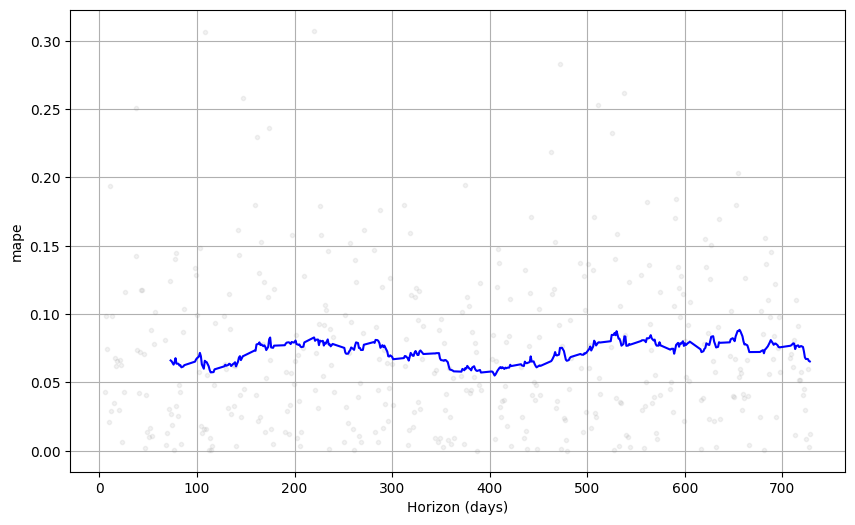

In [62]:
fig_mape = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)

Les points montrent le % absolu d'erreurs pour chaque prédiction de df_cv. La ligne bleue indique le Mean Absolute Percentage error, où la moyenne est prise sur une fenêtre roulante des points. Pour cette prévision, on constate des erreurs d'environ 8 % qui sont typiques pour les prévisions sur ce type d'horizon.